In [34]:
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import numpy as np
from scipy.special import gamma
import longtail
import time
from sklearn.metrics import accuracy_score, roc_auc_score
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sb
###

from scipy.stats import pearsonr, zscore
from MFDFA import fgn
# Plot settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sb.set()
from tqdm import tqdm
import os
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm

# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import minmax_scale
# from sklearn.preprocessing import MaxAbsScaler
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import RobustScaler
# from sklearn.preprocessing import Normalizer
# from sklearn.preprocessing import QuantileTransformer
# from sklearn.preprocessing import PowerTransformer

import sys
sys.path.insert(0, '/directory/tothe/handshakefile/')

import stylised_facts.stylised_facts_data_utilities.createLOB as createLOB
import stylised_facts.stylised_facts_data_utilities.gpyNARX as gpyNARX
%matplotlib inline
import os
os.getcwd()

'/home/ak/Documents/Research/PaperCode'

## hypothesis to test
/1. price jump sizes strongly negative correlated with the volatility jump sizes but the absolute varies (negative) mean and dispersion appear to increase with the volatility level
/2 jumps in returns and jumps in volatilities serve different purposes.
/3 what about the amount of co-jumps. The likelihood of discontinuous movements
4/size distribution of co-jumps increases with volatility? The dispersion and -ve mean of this distribution increases with volatility, threbuy leading to erratic, price co-jumps (tail of this distribution?)
todo:
produce a table that shows day or window, return% t-stat and log-realised variance t-stats
5/ what can we see about the thickness of the tails of the distribution 
6/ Does high intensity activity drive volatility jumps?
7/ What is the relationship of activity to jumps?

In [1]:
# !pip install -e git+https://github.com/Mottl/longtail.git#egg=longtail

In [2]:
ActivityCLockData= '/media/ak/My Passport/Experiment Data/ActivityClockData/'
OHLCData= '/media/ak/My Passport/Experiment Data/OHLCData/'
folderList = os.listdir(ActivityCLockData)
OHLCDataList = os.listdir(OHLCData)

symbols =['FB1','JB1','FV1','G_1']

In [3]:
# OHLCDataList[0].split('+')[1]
createLOB.Volestim.tripower_volatility?

In [4]:
symbolIdx=0
pklList = list(np.sort([s for s in OHLCDataList if (str(symbols[symbolIdx])) in s and ('ohlcFile') in s]))
combinedDF = pd.DataFrame()
for pklIdx, _ in enumerate(pklList):

    pklOHLCFile = "".join((OHLCData,pklList[pklIdx]))
    combinedDF = combinedDF.append(pickle.load(open(pklOHLCFile , "rb")))


In [28]:
# intraday_returns = data.groupby(pd.Grouper(freq="1d")).apply(lambda x: np.log(x / x.shift(1))).dropna()
# # Index of all days
# index = data.groupby(pd.Grouper(freq="1d")).first().dropna().index

In [30]:
combinedDF['MedianOpenClose'] =(combinedDF[['Open','Close']].median(axis=1))

In [31]:
from scipy.special import gamma
x=pd.Series(combinedDF['MedianOpenClose'])

xi = 0.5 * (gamma(5 / 6) / gamma(1 / 2)) ** -3
z = (x.abs() ** (2 / 3) * x.shift(1).abs() ** (2 / 3) * x.shift(-1).abs() ** (2 / 3)).bfill().ffill()

In [32]:

def tripower_volatility(df, columnName, window=50):
    """
    Realized tripower volatility (e.g. Barndorff-Nielsen, Shephard, and Winkel (2006))
    """
    x = pd.Series(df[str(columnName)])
    xi = 0.5 * (gamma(5 / 6) / gamma(1 / 2)) ** -3
    z = (x.abs() ** (2 / 3) * x.shift(1).abs() ** (2 / 3) * x.shift(-1).abs() ** (2 / 3)).bfill().ffill()
    return xi * z.rolling(window).sum()

 /home/ak/Envs/resrPyth3/lib/python3.6/site-packages/numpy/lib/histograms.py:834: RuntimeWarning:invalid value encountered in greater_equal
 /home/ak/Envs/resrPyth3/lib/python3.6/site-packages/numpy/lib/histograms.py:835: RuntimeWarning:invalid value encountered in less_equal


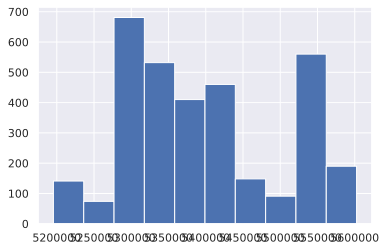

In [33]:
x=tripower_volatility(combinedDF,'MedianOpenClose',window=110)
_=plt.hist(x)

Estimating distributions parameters...
halfnorm (5727573.855844334, 7.367788891906167e-23)
halfcauchy (-0.0023073030850380705, 5221266.953672744)


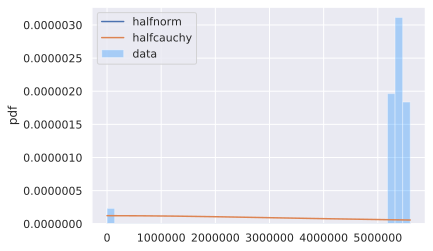

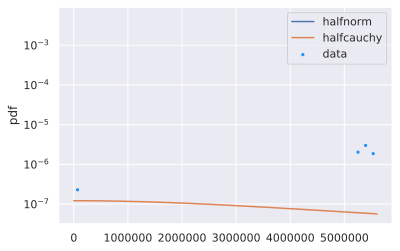

{'halfnorm': (5727573.855844334, 7.367788891906167e-23),
 'halfcauchy': (-0.0023073030850380705, 5221266.953672744)}

In [37]:
x[~np.isfinite(x)]=1
longtail.plot(x)

Estimating distributions parameters...
norm (0.012954682424035645, 0.9728765617583646)
laplace (0.0009144169797343115, 0.787103992319957)
cauchy (-0.006935090833754174, 0.6136158287481435)


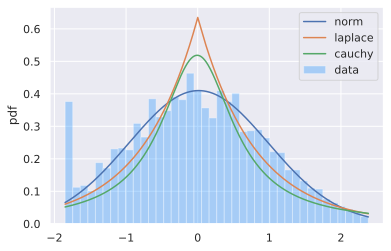

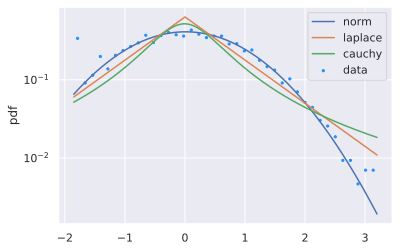

{'norm': (0.012954682424035645, 0.9728765617583646),
 'laplace': (0.0009144169797343115, 0.787103992319957),
 'cauchy': (-0.006935090833754174, 0.6136158287481435)}

In [38]:
scaler = longtail.GaussianScaler()
x_ = scaler.fit_transform(x)
longtail.plot(x_)

(array([ 48.,   7.,  56., 233., 361., 553., 725., 466., 414., 484.]),
 array([2271528.16297706, 2299411.69411477, 2327295.22525248,
        2355178.75639019, 2383062.2875279 , 2410945.81866561,
        2438829.34980332, 2466712.88094103, 2494596.41207874,
        2522479.94321645, 2550363.47435416]),
 <a list of 10 Patch objects>)

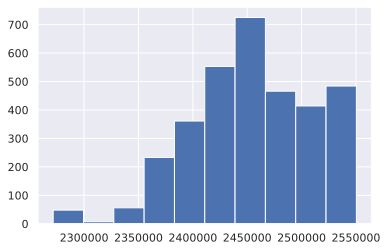

In [10]:
plt.hist(z.rolling(50).sum()*xi)

In [11]:
y=createLOB.Volestim.tripower_volatility(combinedDF,'MedianOpenClose',50)
z= createLOB.Volestim.bipower_variation(combinedDF,'MedianOpenClose',150)

In [12]:
def bipower_variation(dframe, columnName,rollingWindow=50):
    '''
    Bipower Variation (BV) is the sum of the product of absolute time series returns
    :param column: price column
    :return: returns bivariate variation
    '''
    X = dframe[str(columnName)]
    u = np.sqrt(np.pi / 2) ** -2
    pre_log = u * sum([abs(f) * abs(p) for f, p in zip(X[2:], X[1:])])

    # check for log(0)
    try:
        BV = np.log(pre_log)
    except:
        BV = np.nan

    return BV

In [13]:

#     def calculate_bipower_variance(self):
#         n = self.n
#         log_returns = np.absolute(np.log(self.stock).diff())
        
#         variance = (np.pi / 2.0) * (np.float(n) / (n - 1.0)) * np.sum(log_returns[1:] * log_returns[:-1])
#         return variance

In [39]:
# log_abs_returns= np.absolute(np.log(diff()))
# n=len(combinedDF)
# variance = (np.pi / 2.0) * (np.float(n) / (n - 1.0)) * np.sum(log_abs_returns[1:] * log_abs_returns[:-1])

In [15]:
data= pd.DataFrame(combinedDF.MedianOpenClose)
intraday_returns = data.apply(lambda x: np.log(x / x.shift(1))).dropna()
# np.log(data/data.shift(1)).dropna()
intraday_returns
index = data.dropna().index
#  # Some constants
mu_1 = np.sqrt((2 / np.pi))
mu_43 = 2 ** (2 / 3) * gamma(7 / 6) * gamma(1 / 2) ** (-1)

 /home/ak/Envs/resrPyth3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning:divide by zero encountered in log


In [16]:
rolling_variance = intraday_returns.apply(lambda x, window=20: (x**2).rolling(window).sum() )
# Realized absolute variation (Forsberg and Ghysels, 2007)
M=0.6
rav = mu_1 ** (-1) * M ** (-.5) * intraday_returns.apply(lambda x, window =20: x.abs().rolling(window).sum())


In [17]:
bv = mu_1 ** (-2) * intraday_returns.apply(lambda x, window=1: (x.abs().rolling(window).mean() * x.shift(1).abs().rolling(window).mean()).sum())
bv

MedianOpenClose    4.534489
dtype: float64

In [18]:
def realized_quantity(fun,dfram, columnName, frq):
    """Applies the function 'fun' to each day separately"""
    return dframe[string(columnName)].groupby(pd.Grouper(freq=str(frq))).apply(fun)[index]

In [19]:
#  rbv = np.sqrt(np.pi / 2 * 1 / (T / M - 1) * (cts_returns.abs() * cts_returns.shift().abs()).sum())  # (2.6)

#         # If the realized bipower variation is zero, replace it with the the realized volatility
#         if rbv == 0:
#             rbv = np.sqrt(cts_returns.pow(2).sum())

In [20]:
X = combinedDF['MedianOpenClose']
u = np.sqrt(np.pi / 2) ** -2
pre_log = u * sum([abs(f) * abs(p) for f, p in zip(pd.DataFrame.ewm(X[2:], span=10).mean(), pd.DataFrame.ewm(X[2:], span=10).mean())])


In [21]:
import stylised_facts.stylised_facts_data_utilities.createLOB as createLOB

In [22]:
rogersSatchell=createLOB.Volestim(combinedDF).rogersSatchell()
hodgesTompkins=createLOB.Volestim(combinedDF).hodgesTompkins()
bipowerVariation = createLOB.Volestim(combinedDF).bipower_variation('Close')

 /home/ak/Documents/Research/PaperCode/stylised_facts/stylised_facts_data_utilities/createLOB/__init__.py:392: FutureWarning:Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


TypeError: bipower_variation() missing 1 required positional argument: 'columnName'

In [23]:
bipowerVariation

NameError: name 'bipowerVariation' is not defined

In [24]:
max_ = []
min_ = []
top_q = []
median = []
bottom_q = []
realized = []
data = []
realized2= []
windows=[5, 10, 30, 60, 90] 
quantiles=[0.25, 0.75]

In [ ]:
for window in windows:
    estimator = createLOB.Volestim(combinedDF, window=window).hodgesTompkins()
    max_.append(estimator.max())
    top_q.append(estimator.quantile(quantiles[1]))
    median.append(estimator.median())
    bottom_q.append(estimator.quantile(quantiles[0]))
    min_.append(estimator.min())
    data.append(estimator)
    realized.append(estimator[-1:])


In [ ]:
import seaborn as sns
def PlotCones(estiChoice, ohlcDF):
    '''
    1: hodges Tompkins
    2: yang Zhang
    3: Parkinson
    4: Garman Klass
    '''

    max_ = []
    min_ = []
    top_q = []
    median = []
    bottom_q = []
    realized = []
    data = []

    windows=[10, 30, 60, 90] 
    quantiles=[0.25, 0.75]
    for window in windows:
        if estiChoice ==1:
            estimator = createLOB.Volestim(ohlcDF, window=window).hodgesTompkins()
        elif estiChoice== 2:
            estimator = createLOB.Volestim(ohlcDF, window=window).yangZhang()
        elif estiChoice == 3:
            estimator = createLOB.Volestim(ohlcDF, window=window).parkinson()
        elif estiChoice == 4:
            estimator = createLOB.Volestim(ohlcDF, window=window).garmanKlass()
        else:
            estimator = createLOB.Volestim(ohlcDF, window=window).rogersSatchell()
            
        max_.append(estimator.max())
        top_q.append(estimator.quantile(quantiles[1]))
        median.append(estimator.median())
        bottom_q.append(estimator.quantile(quantiles[0]))
        min_.append(estimator.min())
        data.append(estimator)
        realized.append(estimator[-1:])

        
#     size = 15
#     params = {'legend.fontsize': 'large',
#               'figure.figsize': (20, 8),
#               'axes.labelsize': size,
#               'axes.titlesize': size,
#               'xtick.labelsize': size * 0.75,
#               'ytick.labelsize': size * 0.75,
#               'axes.titlepad': 25
    fig = plt.figure(figsize=(16, 9))
    #plt.xlabel('Horizon of Volatility Estimation')

    fig.set_facecolor('white')
    fig.autofmt_xdate()
    left, width = 0.07, 0.65
    bottom, height = 0.2, 0.7
    left_h = left+width+0.02
    rect_cones = [left, bottom, width, height]
    rect_box = [left_h, bottom, 0.17, height]
    cones = plt.axes(rect_cones)
    box = plt.axes(rect_box)
    realized =  list(np.asarray(pd.DataFrame(realized)).flatten())
    # set the plots
    cones.plot(windows, max_, label="Max")
    cones.plot(windows, top_q, label=str(int(quantiles[1]*100)) + " percentile")
    cones.plot(windows, median, label="Median",linewidth=3.0)
    cones.plot(windows, bottom_q, label=str(int(quantiles[0]*100)) + " percentile")
    cones.plot(windows, min_, label="Min")
    cones.plot(windows, realized, 'r-.', label="Realized",linewidth=2.0)
    
   

    # set the x ticks and limits
    cones.set_xticks(windows)
    cones.set_xlim((windows[0]-5, windows[-1]+5))

    # set and format the y-axis labels
    if estiChoice ==1:
        f = lambda x: "%i%%" % round(x*100, 0)
        
    elif estiChoice ==2:
        f = lambda x: "%i%%" % round(x*100, 0)
    elif estiChoice ==3:
        f = lambda x: "%i%%" % round(x*100, 0)
    elif estiChoice ==4:
        f = lambda x: "%i%%" % round(x*1000, 0)
    else:
        f = lambda x: "%i%%" % round(x*100, 0)
    locs = cones.get_yticks()
    cones.set_yticklabels(map(f, locs))

    # turn on the grid
    cones.grid(True, axis='y', which='major', alpha=0.5)

    # set the title
    #cones.set_title(self._estimator + ' (' + self._symbol + ', daily ' + self._start + ' to ' + self._end + ')')
    cones.set_xlabel('Windows')
    cones.set_ylabel('Realised Volatility')

    # set the legend
    cones.legend(loc='upper left', bbox_to_anchor=(-0.003, 1.0), ncol=3)
    # box plot
    box.boxplot(data, notch=1, sym='+')
    box.plot([i for i in range(1, len(windows)+1)], realized, color='r', marker='*', markeredgecolor='k')

    # set and format the y-axis labels
    locs = box.get_yticks()
    box.set_yticklabels(map(f, locs))

    # move the y-axis ticks on the right side
    box.yaxis.tick_right()

    # turn on the grid
    box.grid(True, axis='y', which='major', alpha=0.5)
    
    if estiChoice ==1:
        cones.set_title('Hodges-Tompkings realised volatility estimation (volatility cones) ')
        
        plt.savefig('/home/ak/Documents/Research/Papers/figures/' + 'HodgesTompkinsVolCones' + '.png', dpi=150)
    
    if estiChoice ==2:
        cones.set_title('Yang-Zhang realised volatility estimation (volatility cones) ')
        plt.savefig('/home/ak/Documents/Research/Papers/figures/' + 'YangZhangVolCones' + '.png', dpi=150)
        
    if estiChoice ==3:
        cones.set_title('Parkinson realised volatility estimation (volatility cones) ')
        plt.savefig('/home/ak/Documents/Research/Papers/figures/' + 'ParkinsonVolCones' + '.png', dpi=150)
    if estiChoice ==4:
        cones.set_title('Garman-Klass realised volatility estimation (volatility cones) ')
        plt.savefig('/home/ak/Documents/Research/Papers/figures/' + 'GarmanKlassCones' + '.png', dpi=150)
    plt.show()
        
    return fig, plt



In [ ]:
PlotCones(estiChoice=5, ohlcDF=combinedDF)


#### fig, axs = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')
PlotCones(estiChoice=5, ohlcDF=combinedDF)
axs[1].plot(x, -y)